In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models==1.0.1
!pip install --upgrade albumentations

In [19]:
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")
from lxml import etree
import six
import cv2
import random
import albumentations as A

import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

Tensorflow ver. 2.5.0


'tf.keras'

# Segmentation

In [ ]:
!unzip '/content/drive/MyDrive/data_train_val_test_final.zip'

In [31]:
def display_sample(display_list):
  '''
    Displays image and its mask
    Parameters:
      display_list (list): List of images to display
    Returns:
  '''
  for i in range(len(display_list[1])):
    for j in range(len(display_list[1][0])):
      if display_list[1][i][j] != 29:
        display_list[1][i][j] = 255
  plt.figure(figsize=(18, 18))
  title = ['Input Image', 'True Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def read_mask_file(file):
  '''
    Reads mask file and returns dictionary with keypoints.
    Parameters:
      file (str): Path to .txt file containing keypoints data
    Returns:
      keypoints (dict): Dictionary where key is keypoints unique id and value
                        is x and y coordiantes of keypoint in a given image
  '''
  keypoints = {}
  with open(file) as f:
    for line in f.readlines():
      sline = line.strip().split(" ")
      keypoints[int(sline[0])] = (int(sline[1]), int(sline[2]))
  return keypoints

def get_mask(keypoints, image_shape=(320, 320)):
  '''
    Takes keypoints dictionary and returns mask matrix.
    Parameters:
      keypoints (dict): Dictionary where key is keypoints unique id and value
                        is x and y coordiantes of keypoint in a given image.
    Returns:
      mask (320x320x29): Matrix which represents a mask for a given image. 
                          If value at [100,100,5] == 1, that means that pixel
                          in the image at [100,100] has assigned class 5
  '''
  mask = np.ones((image_shape)) * 29
  for idx, v in keypoints.items():
    for x_i in [-1, 0, 1]:
      for y_i in [-1, 0, 1]:
        ny = min(max(v[0] + y_i, 0), mask.shape[0]-1)
        nx = min(max(v[1] + x_i, 0), mask.shape[1]-1)
        mask[ny][nx] = idx
  return mask
    
def parse_image(image_path):
  '''
    Reads image and its mask and returns them as dictionary.
    Parameters:
      image_path (str): Path to the image.
    Returns:
      (dict) : Dictionary with image and mask
  '''
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  mask_path = image_path.replace("images", "annotations")
  mask_path = mask_path.replace("jpg", "txt")
  keypoints = read_mask_file(mask_path)
  mask = get_mask(keypoints, image_shape = (image.shape[0], image.shape[1]))
  # expand mask dimension from (320, 320) to (320, 320, 1)  
  mask = np.expand_dims(mask, axis=2)
  return {'image': image, 'mask': mask}

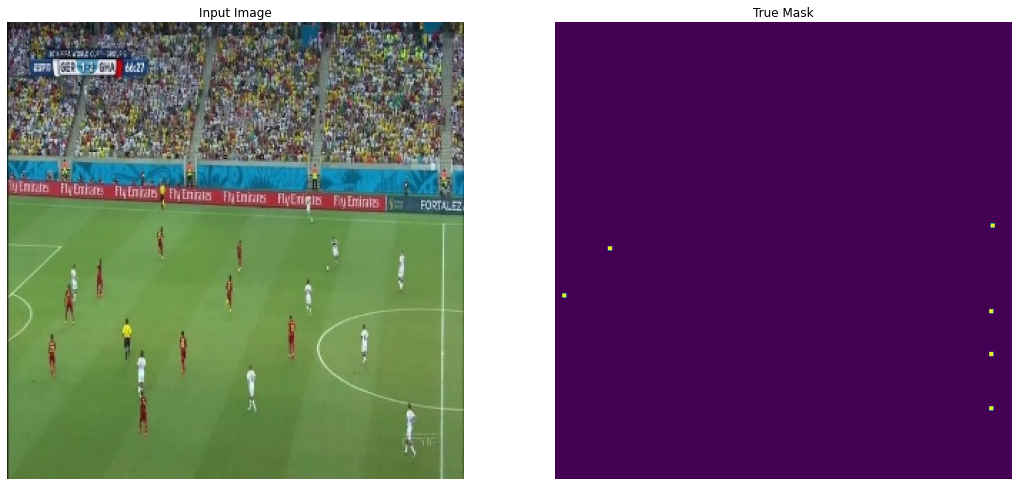

In [32]:
res = parse_image('/content/data_train_val_test_final/train/images/1050.jpg')
display_sample([res['image'], res['mask']])

In [35]:
class Dataset:
  '''
    Dataset for train/test/val 
    Parameters:
      images_path (str) - images directory
      masks_path (str) - masks directory
      n_classes (int) - 29 keypoints classes and 1 background
      augmentation (func) - image segmentations function 
      preprocessing (func) - image preprocessing function
  '''
  def __init__(
        self,
        images_path,        # images directory
        masks_path,         # masks directory
        n_classes=30,       # 29 keypoints classes and 1 background
        augmentation=None,  # image segmentations 
        preprocessing=None, # image preprocessing 
    ):
    self.n_classes = n_classes
    self.images_dataset_paths = [os.path.join(images_path, x) for x in os.listdir(images_path) if os.path.splitext(x)[1] in ('.jpg')]
    self.masks_dataset_paths = [os.path.join(masks_path, x.replace("images", "annotations").replace("jpg", "txt")) for x in self.images_dataset_paths]
    self.len = len(self.images_dataset_paths)
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.LEFT_RIGHT_FLIP = {
        0: 13, 1: 14, 2: 15, 3: 16, 4: 17, 5: 18, 6: 19, 7: 20,
        8: 21, 9: 22, 10: 10, 11: 11, 12: 12, 13: 0, 14: 1, 15: 2,
        16: 3, 17: 4, 18: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 27,
        24: 28, 25: 25, 26: 26, 27: 23, 28: 24,
    }
    
  def __getitem__(self, i):
    'Return a pair of image and mask after applying augmentations'
    
    image = cv2.cvtColor(cv2.imread(self.images_dataset_paths[i]), cv2.COLOR_BGR2RGB)
    keypoints = read_mask_file(self.masks_dataset_paths[i])
    if random.random() < 0.5:
      image = cv2.flip(image, 1)
      flipped_keypoints = {}
      for idx, v in keypoints.items():
        new_idx = self.LEFT_RIGHT_FLIP[idx]
        new_y = image.shape[1] - 1 - min(v[1], image.shape[1]-1)
        new_x = min(v[0], image.shape[0]-1)
        flipped_keypoints[new_idx] = (new_x, new_y)
      keypoints = flipped_keypoints

    _mask = get_mask(keypoints, image_shape=(image.shape[0], image.shape[1]))
    
    mask = np.zeros((image.shape[0], image.shape[1], self.n_classes))
    for i in range(len(_mask)):
      for j in range(len(_mask[0])):
        mask[i][j][int(_mask[i][j])] = 1

    if self.augmentation:
      sample = self.augmentation(image=image)
      image = sample["image"]

    if self.preprocessing:
      sample = self.preprocessing(image=image)
      image = sample['image']

    return image, mask

  def __len__(self):
    'Returns the number of elements in dataset'
    return len(self.images_dataset_paths)

In [36]:
class DataGenerator(tf.keras.utils.Sequence):
  '''
    Data geenrator for train/test/val 
    Parameters:
      dataset (Dataset) - Dataset class train/val/test
      batch_size (int) - batch size for training (4) and val/test (1)
      shuffle (boolean) - shuffle data after each epoch
  '''
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(dataset.len)
    self.on_epoch_end()

  def __getitem__(self, i):
    'Generate one batch of data'
    indexes = self.indexes[i * self.batch_size : (i+1) * self.batch_size]
    images = []
    masks = []
    for j in indexes:
      image, mask = self.dataset[j]
      images.append(image)
      masks.append(mask)
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

  def __len__(self):
    'Denotes the number of batches per epoch'
    return len(self.indexes) // self.batch_size

  def on_epoch_end(self):
    'Updates indexes after each epoch by shuffling them'
    if self.shuffle:
      np.random.shuffle(self.indexes)
      #self.indexes = np.random.permutation(self.indexes)

In [37]:
def get_training_augmentation():
  'Returns image augmentations'
  train_transform = [
    A.OneOf(
        [
          A.RandomBrightnessContrast(p=1), 
        ], 
          p=0.9,),
    A.OneOf(
        [
          A.Sharpen(p=1),
          A.Blur(blur_limit=3, p=1),
          A.MotionBlur(blur_limit=3, p=1),
        ],
          p=0.9,
    )
  ]
  return A.Compose(train_transform)

def get_preprocessing(preprocessing_fn):
  'Returns preprocessing function'
  _transform = [
      A.Lambda(image=preprocessing_fn),
  ]
  return A.Compose(_transform)

### Model parameters

In [38]:
# model parameters
backbone='resnet34'
lr = 0.0001
epochs = 100
batch_size = 4
model_name = '/content/drive/MyDrive/UNETmodel/UNET_epoch_{epoch:03d}_iou_{val_iou_score:04f}'+backbone+'.h5'

model = sm.Unet(backbone_name=backbone,
                classes=30,
                activation="softmax",
                input_shape=(320, 320, 3),
                encoder_weights="imagenet")

### Load train, validation and test datasets

In [39]:
x_train_path = "/content/data_train_val_test_final/train/images"
y_train_path = "/content/data_train_val_test_final/train/annotations"

x_val_path ="/content/data_train_val_test_final/val/images"
y_val_path = "/content/data_train_val_test_final/val/annotations"

x_test_path ="/content/data_train_val_test_final/test/images"
y_test_path = "/content/data_train_val_test_final/test/annotations"

train_dataset = Dataset(x_train_path, 
                        y_train_path, 
                        augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone)))

val_dataset = Dataset(x_val_path, 
                      y_val_path,
                      preprocessing=get_preprocessing(sm.get_preprocessing(backbone)))

test_dataset = Dataset(x_test_path, 
                       y_test_path,
                       preprocessing=get_preprocessing(sm.get_preprocessing(backbone)))

train_dataloader = DataGenerator(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataGenerator(val_dataset, batch_size=1)
test_dataloader = DataGenerator(test_dataset, batch_size=1)

### Train segmentation model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
              loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(), 
              metrics=[sm.metrics.IOUScore(threshold=0.5)])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_name, 
        save_weights_only=True, 
        save_best_only=True, 
        mode="min",
        save_freq='epoch'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5, 
        factor=0.1,
        verbose=1,  
    ),
]

history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
)

### Evaluate segmentation model

In [40]:
model.load_weights('/content/drive/MyDrive/UNETmodel/UNET__iou_0.836167_resnet34.h5')

model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
              loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(), 
              metrics=[sm.metrics.IOUScore(threshold=0.5)])

scores = model.evaluate(val_dataloader)

print("Loss: {:.4}".format(scores[0]))
print("IoU: {:.4}".format(scores[1]))

58/58 [==============================] - 11s 149ms/step - loss: 0.1522 - iou_score: 0.8308
Loss: 0.1522
IoU: 0.8308


# Player detection

In [ ]:
!unzip '/content/drive/MyDrive/tracking_dataset_final.zip'

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

%cd yolov5
%pip install -qr requirements.txt  # install dependencies
import torch
from IPython.display import Image, clear_output  # to display images
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
# update coco128.yaml file with the following

path: /content/tracking_dataset_final_1024
train: images/train
val: images/val  
test: images/test  

# Classes
nc: 1  # number of classes
names: [ 'person' ]  # class names

In [ ]:
!python train.py --img 320 --batch 16 --epochs 5 --data coco128.yaml --weights yolov5m.pt

# Final models

In [ ]:
# trained model weights
!unzip '/content/drive/MyDrive/yolotrain1024.zip'

!git clone https://github.com/ultralytics/yolov5  # clone repo

%cd yolov5
%pip install -qr requirements.txt  # install dependencies
import torch
from IPython.display import Image, clear_output  # to display images
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# YOLO imports 
import argparse
import sys
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn

# %cd yolov5
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, colorstr, non_max_suppression, \
    apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_sync

In [7]:
YOLO_WEIGHTS = '/content/content/yolov5/runs/train/exp/weights/best.pt'

### Pitch class

In [41]:
class Pitch():
  'Class that represents 2D pitch with players'
  def __init__(self, 
               image_path, 
               players_boxes,
               show_image_regions=False, 
               show_colors_bar=False):
    '''
      Parameters:
        image_path (str) - path to the image from the dataset
        players_boxes (int) - (x1,y1,x2,y2) coordiantes of top left and bottom right corners
        show_image_regions (boolean) - plot image regions  
        show_colors_bar (boolean) - plot color bars
    '''
    self.image_path = image_path
    self.players_boxes = players_boxes
    self.show_image_regions = show_image_regions
    self.show_colors_bar = show_colors_bar

    self.image = cv2.imread(image_path)
    self.player_objects = self._load_players()
    self.cluster_players()

  def cluster_players(self):
    'Clusters all players into two teams by their color'

    player_colors = []
    for p in self.player_objects:
      player_colors.append(list(p.player_color))

    kmean = KMeans(n_clusters = 2)
    kmean.fit(player_colors)

    for player, team_color_id in zip(self.player_objects, kmean.labels_):
      player.team_color = kmean.cluster_centers_[team_color_id]

  def show_pitch_with_players(self, with_input_image=False):
    'Displays input image with detected players in bounding box'

    image_copy = self.image.copy()
    for player in self.player_objects:
      x1, y1, x2, y2 = player.get_box_coordinates()
      image_copy = cv2.rectangle(image_copy, (x1, y1), (x2, y2), (player.team_color) , 2) 
    if with_input_image:
      self._visualize(input_image = self.image, detected_players = image_copy)
    else:
      self._visualize(detected_players = image_copy)

  def show_pitch_with_players_H(self, homography, with_input_image=False):
    'Displays 2d reprezentation of the pitch with detected players'

    for player in self.player_objects:
      c = self.get_field_coordinates(player.get_box_coordinates(), homography)
      player.coordinate_2d = c
    
    pitch_image_2d = cv2.imread("/content/drive/MyDrive/pitch_template.png")
    for player in self.player_objects:
      x1 = int(player.coordinate_2d[0])
      y1 = int(player.coordinate_2d[1])
      x2 = int(player.coordinate_2d[0]+5)
      y2 = int(player.coordinate_2d[1]+5)
      pitch_image_2d = cv2.rectangle(pitch_image_2d, (x1, y1), (x2, y2), (player.team_color), 4) 
    
    pitch_image_2d = cv2.resize(pitch_image_2d, (400,320))

    if with_input_image:
      self._visualize(input_image = self.image, top_down_view = pitch_image_2d)
    else:
      self._visualize(top_down_view = pitch_image_2d)

  def get_field_coordinates(self, player, pred_h):
    'Returns players final coordinates in 2D space after applying homography'

    x_1 = player[0]
    y_1 = player[1]
    x_2 = player[2]
    y_2 = player[3]
    x = (x_1 + x_2) / 2.0 
    y = max(y_1, y_2)
    pts = np.array([float(x), float(y)])
    dst = self._warp_point(pts, np.linalg.inv(pred_h))
    return dst

  def _warp_point(self, point, homography):
    'Returns point after applying homography'
    dst = cv2.perspectiveTransform(np.array(point).reshape(-1, 1, 2), homography)
    return dst[0][0]
    
  def _load_players(self):
    'Creates and return Player objects from player bounding boxes'

    players_objects = []
    for x1, y1, x2, y2 in self.players_boxes:
      players_objects.append(Player(box = [int(x1), int(y1), int(x2), int(y2)], 
                                    image = self.image,
                                    show_image_regions=self.show_image_regions, 
                                    show_colors_bar=self.show_image_regions))
    return players_objects

  def _visualize(self, **images):
    'Plot images'
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()


### Player class

In [44]:
class Player():
  def __init__(self, 
               box, 
               image, 
               show_image_regions=False, 
               show_colors_bar=False):
    '''
      Class representing a player and his team color
      Parameters:
        box (int) - [x1,y1,x2,y2] coordinates of top left and bottom right 
        image (str) - image of the pitch where player was detected
        show_image_regions (boolean) - plot image regions 
        show_colors_bar (boolean) - plot color bar
    '''
    self.show_image_regions = show_image_regions
    self.show_colors_bar = show_colors_bar
    self.box = box
    self.coordinate_2d = None
    self.image = image
    self.player_color = self.cluster_pixels()
    self.team_color = None

  def get_box_coordinates(self):
    'Return bounding box coordinates'
    return self.box
    
  def get_player_image_region(self):
    'Return image region of player on original input image'
    x_1 = self.box[0]
    y_1 = self.box[1]
    x_2 = self.box[2]
    y_2 = self.box[3]
    player_region = self.image[y_1:y_2,x_1:x_2]
    if self.show_image_regions:
      self._visualize(player = player_region)
    return player_region

  def cluster_pixels(self):
    '''
      Clusters pixels of detected player region. 
      Pick cluster with fewer elements as player final color
    '''
    player_region = self.get_player_image_region()
    player_region = player_region.reshape((player_region.shape[0] * player_region.shape[1], 3))

    kmeans = KMeans(n_clusters = 2)
    kmeans.fit(player_region)
    min_idx = np.argmin(self._centroid_histogram(kmeans))
    player_color = kmeans.cluster_centers_[min_idx]

    if self.show_colors_bar:
      hist = self._centroid_histogram(kmeans)
      bar = self._plot_colors(hist, kmeans.cluster_centers_)
      plt.figure()
      plt.axis("off")
      plt.imshow(bar)
      plt.show()
    return player_color

  def _centroid_histogram(self, kmeans):
    'Histogram of colors in players region'
    numLabels = np.arange(0, len(np.unique(kmeans.labels_)) + 1)
    (hist, _) = np.histogram(kmeans.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

  def _plot_colors(self, hist, centroids):
    'Plots color bar'
    bar = np.zeros((50, 150, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(hist, centroids):
      endX = startX + (percent * 150)
      cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                    color.astype("uint8").tolist(), -1)
      startX = endX
    return bar
  
  def __str__(self):
    return "player = [x1 {}] [y1 {}] [x2 {}] [y2 {}]".format(box[0], box[1], box[2], box[3])

  def _visualize(self, **images):
    'Plot images'
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

### YOLO model

In [45]:
class YOLO():
  '''
    Class representing trained yolo model for player
    detection from ultralytics/yolov5
  '''
  def __init__(self, 
               weights=YOLO_WEIGHTS, 
               imgsz=320,
               conf_thres=0.50,
               iou_thres=0.45,
               classes=0):
    self.weights = weights
    self.imgsz = imgsz
    self.conf_thres = conf_thres
    self.iou_thres = iou_thres
    self.classes = classes
    
  def detect_players(self, source):
    'Returns list of detected players bounding boxes'
    PLAYERS = []

    #set_logging()
    device = select_device('')

    # Load model
    w = self.weights[0] if isinstance(self.weights, list) else self.weights
    pt = w.endswith('.pt')
    stride, names = 64, [f'class{i}' for i in range(1000)]  # assign defaults
      
    model = attempt_load(self.weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
      
    imgsz = check_img_size(self.imgsz, s=stride)  # check image size

    # Dataloader
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
    bs = 1  # batch_size
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    if pt and device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
      if pt:
        img = torch.from_numpy(img).to(device)
        img = img.float()   # uint8 to fp16/32
      elif onnx:
        img = img.astype('float32')
      img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if len(img.shape) == 3:
        img = img[None]  # expand for batch dim

        # Inference
        if pt:
          visualize = False
          pred = model(img, augment=False, visualize=visualize)[0]
        elif onnx:
          pred = torch.tensor(session.run([session.get_outputs()[0].name], {session.get_inputs()[0].name: img}))

        # NMS
        pred = non_max_suppression(pred, self.conf_thres, self.iou_thres, self.classes, False, max_det=1000)

        # Process predictions
        for i, det in enumerate(pred):  # detections per image
              
          p, s, im0, frame = path, '', im0s.copy(), getattr(dataset, 'frame', 0)

          s += '%gx%g ' % img.shape[2:]  # print string
          gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
          imc = im0  # for save_crop
          if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            print("\n")
            for *xyxy, conf, cls in reversed(det):
              line = (cls, *xyxy, conf)   # label format
              cls, x1, y1, x2, y2, conf = line[0].item(), line[1].item(), \
                                          line[2].item(), line[3].item(), \
                                          line[4].item(), line[5].item()  
              if conf >= self.conf_thres:
                PLAYERS.append([x1, y1, x2, y2])
    return PLAYERS

### Segmentation model

In [71]:
SOURCE_DESTINATION_MAP = {
  0: [2, 2],      1: [2, 65],     2: [52, 65],    3: [2, 117],
  4: [18, 117],   5: [2, 204],    6: [18, 204],   7: [2, 254],
  8: [52, 254],   9: [2, 318],    10: [160, 2],   11: [160, 160],
  12: [160, 318], 13: [318, 2],   14: [318, 65],  15: [269, 65],
  16: [318, 117], 17: [303, 117], 18: [318, 204], 19: [303, 204],
  20: [318, 254], 21: [269, 254], 22: [318, 318], 23: [52, 128],
  24: [52, 193],  25: [160, 117], 26: [160, 204], 27: [269, 128],  
	28: [269, 192],
}

class SegmentationModel():
  'Class representing UNet segmentaion model for keypoints detection'
  def __init__(self, 
               weights_path='/content/drive/MyDrive/UNETmodel/UNET_iou_0.836167_resnet34.h5',
               backbone="resnet34",
               input_shape=(320, 320),
               ):
    self.weights_path = weights_path
    self.backbone=backbone
    self.input_shape=input_shape
    self.template = cv2.resize(cv2.cvtColor(cv2.imread('/content/drive/MyDrive/pitch_template.png'), 
                                                              cv2.COLOR_BGR2RGB),(1280,720))/255.
    self.model = sm.Unet(backbone,
                        classes=30,
                        activation="softmax",
                        input_shape=(input_shape[0], input_shape[1], 3),
                        encoder_weights="imagenet")
    self.model.load_weights(self.weights_path)
    self.model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
                        loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(), 
                        metrics=[sm.metrics.IOUScore(threshold=0.5)])
    
  def predict(self, image_path, show_mask=False):
    'Predicts mask for a given image'

    image = cv2.imread(image_path)
    image_org = image
    preprocessing = sm.get_preprocessing(self.backbone) 
    image = preprocessing(image)
    predicted_mask = self.model.predict(np.array([image]))
    if show_mask:
      self.visualize(
            input_image=image_org,
            predicted_mask=predicted_mask[..., -1].squeeze())
    return predicted_mask

  def get_points_from_mask(self, mask):
    'Returns source -> destination mapping of detected keypoints'
    
    # get keypoints
    keypoints = {}
    idxs = np.argwhere(mask[0][:, :, :-1] > 0.9)
    for x, y, cls in idxs:
      if cls in keypoints.keys():
        keypoints[cls][0].append(x)
        keypoints[cls][1].append(y)
      else:
        keypoints[cls] = [[x], [y]]   
    for cls in keypoints.keys():
      keypoints[cls] = [np.mean(keypoints[cls][1]) , np.mean(keypoints[cls][0])]
    
    # get source and destination points mapping
    src_pts = []
    dst_pts = []
    for cls, xy in keypoints.items():
      # print("{} - {}".format(id_kp, v))
      src_pts.append(xy)                            # x and y for calculated mean x,y on image
      dst_pts.append(SOURCE_DESTINATION_MAP[cls])   # find that class on target image
      # list_ids.append(cls)
    src, dst = np.array(src_pts), np.array(dst_pts)
    return src, dst
  
  def __call__(self, image_path):
    'Return predicted homography for a given image'
    
    predicted_mask = self.predict(image_path=image_path, show_mask=True)
    src, dst = self.get_points_from_mask(predicted_mask)
    predicted_h, _ = cv2.findHomography(dst, src, cv2.RANSAC, 20)
    warped_perspective = cv2.warpPerspective(cv2.resize(self.template, (320,320)), 
                                    predicted_h, 
                                    dsize=(320,320))

    image = cv2.imread(image_path)
    self.visualize(input_image=image, 
                    warped_perspective=warped_perspective)
    return predicted_h

  def visualize(self, **images):
    'Plot images'
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

### Examples

In [79]:
TEST_IMAGE_PATH = '/content/data_train_val_test_final/test/images/1000.jpg'

In [82]:
yolo_model = YOLO()
players = yolo_model.detect_players(source=TEST_IMAGE_PATH)

image 1/1 /content/data_train_val_test_final/val/images/1000.jpg: 



In [80]:
segmentation_model = SegmentationModel()

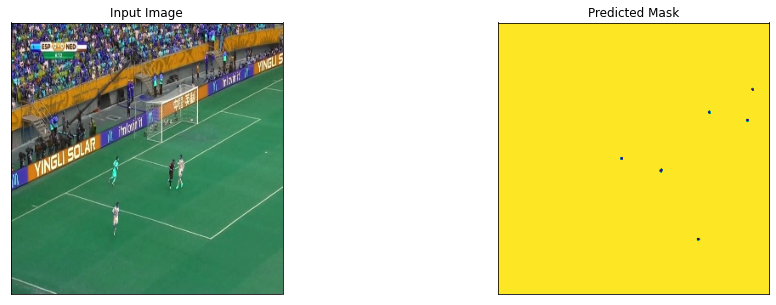

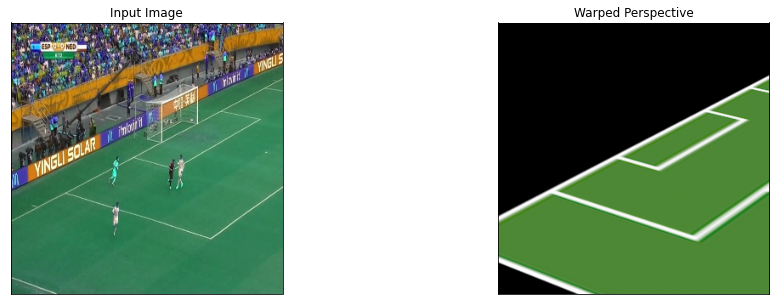

In [81]:
pred_H = segmentation_model(TEST_IMAGE_PATH)

In [83]:
pitch = Pitch(image_path=TEST_IMAGE_PATH,
              players_boxes=players,
              show_image_regions=False, 
              show_colors_bar=False)

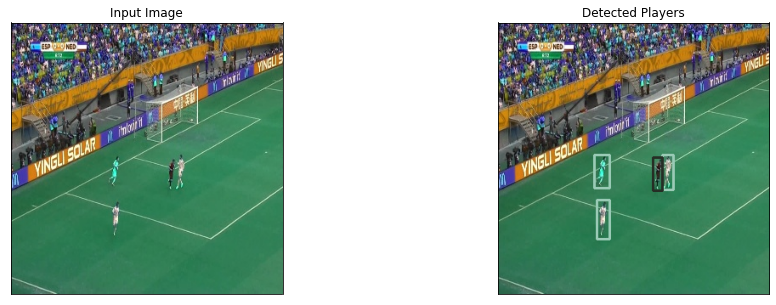

In [84]:
pitch.show_pitch_with_players(with_input_image=True)

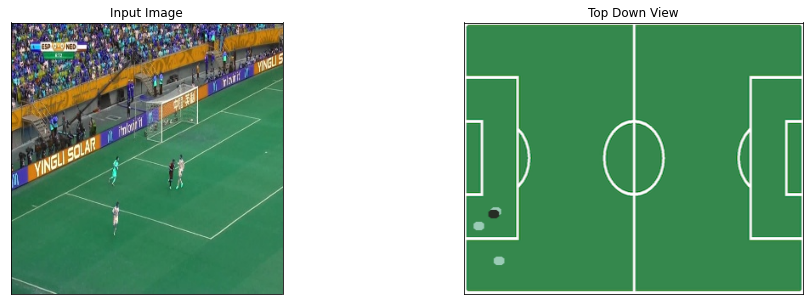

In [85]:
pitch.show_pitch_with_players_H(pred_H, with_input_image=True)